# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                     
Sample_078  H7BYX6                                                19.481
Sample_190  P02458;P02458-1                                       17.438
Sample_186  P40925;P40925-3                                       18.415
Sample_129  Q99584                                                10.231
Sample_025  O94856;O94856-11;O94856-13;O94856-6;O94856-7;X6RKN2   19.060
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups   
Sample_042  Q9GZT8;Q9GZT8-2     15.382
Sample_174  A0A087WTA8;P08123   17.537
Sample_122  P02538              15.555
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.819
            A0A075B6Q5                 12.608
            A0A075B6R2                 11.505
            A0A075B6S5                 13.259
            A0A087WSY4                 13.354
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.517
            Q9UI40;Q9UI40-2            11.384
            Q9UIW2                     11.896
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.612
            Q9UP79                     13.872
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.623,15.050,16.842,19.863,16.591,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.026,19.067,...,15.528,15.576,13.976,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,16.009,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.870,17.705,17.039,15.436,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.355,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.888,15.345,17.084,18.708,14.249,19.433,11.766,11.371
Sample_207,15.739,16.877,15.469,16.898,14.441,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,12.819,...,16.012,15.178,12.394,15.050,16.842,19.863,12.920,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,11.989,19.067,16.188,...,15.528,15.576,14.506,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.212,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,13.986,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.019,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.337,15.345,17.084,18.708,14.249,19.433,12.764,13.320
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 373.66it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.36it/s]

100%|██████████| 2/2 [00:00<00:00,  4.34it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.55it/s]

100%|██████████| 3/3 [00:00<00:00,  3.94it/s]

100%|██████████| 3/3 [00:00<00:00,  4.17it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.55it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.84it/s]

100%|██████████| 4/4 [00:01<00:00,  3.26it/s]

100%|██████████| 4/4 [00:01<00:00,  3.57it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.74it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.57it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.35it/s]

100%|██████████| 5/5 [00:01<00:00,  3.30it/s]

100%|██████████| 5/5 [00:01<00:00,  3.47it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.03it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.62it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.98it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.94it/s]

100%|██████████| 6/6 [00:01<00:00,  3.05it/s]

100%|██████████| 6/6 [00:01<00:00,  3.20it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.38it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.65it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.11it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.90it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.86it/s]

100%|██████████| 7/7 [00:02<00:00,  2.85it/s]

100%|██████████| 7/7 [00:02<00:00,  3.08it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  6.00it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.75it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.41it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.17it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.98it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  3.12it/s]

100%|██████████| 8/8 [00:02<00:00,  3.00it/s]

100%|██████████| 8/8 [00:02<00:00,  3.25it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.21it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.01it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.42it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.30it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.11it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  3.10it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.04it/s]

100%|██████████| 9/9 [00:02<00:00,  3.01it/s]

100%|██████████| 9/9 [00:02<00:00,  3.27it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.59it/s]

 30%|███       | 3/10 [00:00<00:01,  3.87it/s]

 40%|████      | 4/10 [00:01<00:01,  3.57it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.27it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.03it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.98it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.91it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.88it/s]

100%|██████████| 10/10 [00:03<00:00,  3.07it/s]

100%|██████████| 10/10 [00:03<00:00,  3.20it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.44it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.18it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.44it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.20it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.00it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.94it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.84it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.83it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.81it/s]

100%|██████████| 11/11 [00:03<00:00,  2.93it/s]

100%|██████████| 11/11 [00:03<00:00,  3.10it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.89it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.12it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.92it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.57it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.15it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.07it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.19it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.22it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.42it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.56it/s]

100%|██████████| 12/12 [00:04<00:00,  2.75it/s]

100%|██████████| 12/12 [00:04<00:00,  2.60it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.53it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.98it/s]

 31%|███       | 4/13 [00:01<00:02,  3.57it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.31it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.78it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.38it/s]

 62%|██████▏   | 8/13 [00:02<00:02,  2.24it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.23it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.25it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.11it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.19it/s]

100%|██████████| 13/13 [00:05<00:00,  1.97it/s]

100%|██████████| 13/13 [00:05<00:00,  2.41it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.57it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.72it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.45it/s]

 36%|███▌      | 5/14 [00:02<00:03,  2.29it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.15it/s]

 50%|█████     | 7/14 [00:03<00:03,  1.92it/s]

 57%|█████▋    | 8/14 [00:03<00:03,  1.90it/s]

 64%|██████▍   | 9/14 [00:04<00:02,  2.05it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.15it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.39it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.39it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.45it/s]

100%|██████████| 14/14 [00:05<00:00,  2.71it/s]

100%|██████████| 14/14 [00:05<00:00,  2.36it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  4.07it/s]

 20%|██        | 3/15 [00:00<00:03,  3.55it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.95it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.72it/s]

 40%|████      | 6/15 [00:02<00:04,  2.20it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.04it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  1.92it/s]

 60%|██████    | 9/15 [00:04<00:03,  1.89it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.95it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.07it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.16it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.32it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.50it/s]

100%|██████████| 15/15 [00:06<00:00,  2.58it/s]

100%|██████████| 15/15 [00:06<00:00,  2.36it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.001      0.046 0.016          0.793 0.319       0.124   
2             0.004 0.002      0.049 0.006          0.756 0.092       0.714   
3             0.004 0.000      0.047 0.001          0.749 0.092       0.712   
4             0.004 0.001      0.049 0.005          0.786 0.100       0.778   
5             0.004 0.000      0.050 0.010          0.778 0.096       0.776   
6             0.004 0.000      0.048 0.004          0.809 0.091       0.802   
7             0.004 0.002      0.048 0.002          0.811 0.089       0.807   
8             0.004 0.000      0.048 0.006          0.808 0.081       0.802   
9             0.004 0.002      0.049 0.008          0.806 0.079       0.794   
10            0.005 0.003      0.062 0.025          0.806 0.085       0.793   
11            0.005 0.003      0.061 0.023          0.802 0.085       0.796   
12            0.005 0.004      0.063 0.029          0.796 0.084       0.789   
13            0.006 0.005      0.070 0.027          0.790 0.084       0.786   
14            0.005 0.003      0.062 0.020          0.802 0.078       0.783   
15            0.006 0.004      0.087 0.040          0.809 0.090       0.786   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.081   0.207 0.121                  0.554 0.039        0.855   
2          0.100   0.726 0.060                  0.768 0.047        0.861   
3          0.092   0.725 0.070                  0.766 0.057        0.860   
4          0.094   0.777 0.074                  0.809 0.063        0.894   
5          0.091   0.772 0.068                  0.804 0.058        0.898   
6          0.097   0.800 0.069                  0.829 0.058        0.914   
7          0.097   0.804 0.068                  0.832 0.058        0.912   
8          0.095   0.801 0.066                  0.830 0.056        0.911   
9          0.097   0.796 0.069                  0.826 0.058        0.910   
10         0.097   0.795 0.071                  0.825 0.060        0.908   
11         0.103   0.795 0.074                  0.825 0.062        0.907   
12         0.102   0.788 0.073                  0.819 0.061        0.905   
13         0.098   0.783 0.071                  0.815 0.060        0.904   
14         0.097   0.788 0.068                  0.820 0.057        0.906   
15         0.092   0.793 0.069                  0.823 0.057        0.907   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.824 0.091        210.000 0.000  
2          0.056                  0.837 0.066        210.000 0.000  
3          0.053                  0.839 0.061        210.000 0.000  
4          0.049                  0.877 0.058        210.000 0.000  
5          0.047                  0.882 0.052        210.000 0.000  
6          0.046                  0.899 0.052        210.000 0.000  
7          0.049                  0.897 0.054        210.000 0.000  
8          0.049                  0.897 0.054        210.000 0.000  
9          0.049                  0.896 0.054        210.000 0.000  
10         0.049                  0.894 0.054        210.000 0.000  
11         0.050                  0.893 0.055        210.000 0.000  
12         0.050                  0.890 0.056        210.000 0.000  
13         0.050                  0.890 0.054        210.000 0.000  
14         0.050                  0.890 0.055        210.000 0.000  
15         0.047                  0.894 0.051 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 474.84it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.52it/s]

100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.51it/s]

100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

100%|██████████| 3/3 [00:00<00:00,  3.38it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.67it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.68it/s]

100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.16it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.77it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.53it/s]

100%|██████████| 5/5 [00:01<00:00,  2.45it/s]

100%|██████████| 5/5 [00:01<00:00,  2.64it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.62it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.22it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.72it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.31it/s]

100%|██████████| 6/6 [00:02<00:00,  2.11it/s]

100%|██████████| 6/6 [00:02<00:00,  2.44it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.96it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.15it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.82it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.58it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.08it/s]

100%|██████████| 7/7 [00:03<00:00,  1.77it/s]

100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.38it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.21it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.64it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.62it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.57it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.52it/s]

100%|██████████| 8/8 [00:03<00:00,  2.10it/s]

100%|██████████| 8/8 [00:03<00:00,  2.48it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.18it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.62it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.25it/s]

 56%|█████▌    | 5/9 [00:02<00:01,  2.13it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.20it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.33it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.42it/s]

100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

100%|██████████| 9/9 [00:03<00:00,  2.39it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:02,  3.72it/s]

 30%|███       | 3/10 [00:00<00:02,  3.15it/s]

 40%|████      | 4/10 [00:01<00:02,  2.99it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.90it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.87it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.93it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.46it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.21it/s]

100%|██████████| 10/10 [00:04<00:00,  2.05it/s]

100%|██████████| 10/10 [00:04<00:00,  2.49it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:03,  2.86it/s]

 27%|██▋       | 3/11 [00:01<00:03,  2.61it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.53it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.58it/s]

 55%|█████▍    | 6/11 [00:02<00:01,  2.59it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.69it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.72it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.75it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.76it/s]

100%|██████████| 11/11 [00:04<00:00,  2.73it/s]

100%|██████████| 11/11 [00:04<00:00,  2.69it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.04it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.04it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.55it/s]

 42%|████▏     | 5/12 [00:02<00:03,  2.14it/s]

 50%|█████     | 6/12 [00:02<00:03,  1.89it/s]

 58%|█████▊    | 7/12 [00:03<00:02,  1.82it/s]

 67%|██████▋   | 8/12 [00:03<00:02,  1.90it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  1.95it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.04it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  1.85it/s]

100%|██████████| 12/12 [00:05<00:00,  1.81it/s]

100%|██████████| 12/12 [00:05<00:00,  2.02it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.71it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.72it/s]

 31%|███       | 4/13 [00:01<00:02,  3.33it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.98it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.36it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.13it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.01it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.06it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.25it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.29it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  1.99it/s]

100%|██████████| 13/13 [00:05<00:00,  1.73it/s]

100%|██████████| 13/13 [00:05<00:00,  2.20it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.49it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.55it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.26it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.00it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.59it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.22it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.02it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.16it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.22it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.00it/s]

 86%|████████▌ | 12/14 [00:05<00:01,  1.91it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  1.67it/s]

100%|██████████| 14/14 [00:06<00:00,  1.52it/s]

100%|██████████| 14/14 [00:06<00:00,  2.07it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:05,  2.55it/s]

 20%|██        | 3/15 [00:01<00:06,  1.88it/s]

 27%|██▋       | 4/15 [00:02<00:06,  1.75it/s]

 33%|███▎      | 5/15 [00:02<00:05,  1.79it/s]

 40%|████      | 6/15 [00:03<00:04,  1.89it/s]

 47%|████▋     | 7/15 [00:03<00:03,  2.03it/s]

 53%|█████▎    | 8/15 [00:04<00:03,  2.11it/s]

 60%|██████    | 9/15 [00:04<00:02,  2.16it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.26it/s]

 73%|███████▎  | 11/15 [00:05<00:01,  2.41it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.53it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.60it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.56it/s]

100%|██████████| 15/15 [00:06<00:00,  2.35it/s]

100%|██████████| 15/15 [00:06<00:00,  2.20it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.005      0.082 0.045          0.000 0.000       0.000   
2             0.005 0.004      0.065 0.024          0.693 0.110       0.607   
3             0.005 0.004      0.071 0.026          0.784 0.095       0.706   
4             0.005 0.004      0.089 0.042          0.789 0.087       0.738   
5             0.007 0.007      0.087 0.035          0.827 0.080       0.792   
6             0.007 0.007      0.076 0.032          0.827 0.085       0.774   
7             0.005 0.004      0.080 0.031          0.825 0.082       0.773   
8             0.009 0.009      0.085 0.030          0.820 0.087       0.773   
9             0.008 0.006      0.095 0.043          0.819 0.082       0.772   
10            0.007 0.006      0.088 0.031          0.816 0.085       0.774   
11            0.011 0.009      0.097 0.040          0.819 0.086       0.768   
12            0.007 0.005      0.093 0.032          0.807 0.082       0.798   
13            0.007 0.006      0.090 0.036          0.802 0.081       0.793   
14            0.005 0.004      0.067 0.029          0.793 0.083       0.782   
15            0.009 0.007      0.087 0.034          0.827 0.085       0.793   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.853   
2          0.105   0.642 0.088                  0.702 0.069        0.783   
3          0.118   0.736 0.082                  0.779 0.065        0.870   
4          0.103   0.757 0.075                  0.795 0.060        0.894   
5          0.104   0.804 0.068                  0.834 0.056        0.927   
6          0.100   0.795 0.072                  0.826 0.058        0.926   
7          0.101   0.793 0.073                  0.825 0.059        0.923   
8          0.103   0.791 0.072                  0.822 0.058        0.922   
9          0.103   0.790 0.070                  0.822 0.056        0.920   
10         0.101   0.790 0.070                  0.821 0.057        0.918   
11         0.103   0.787 0.070                  0.820 0.057        0.921   
12         0.094   0.799 0.067                  0.828 0.057        0.923   
13         0.090   0.793 0.060                  0.823 0.051        0.925   
14         0.097   0.782 0.064                  0.814 0.054        0.923   
15         0.093   0.804 0.060                  0.833 0.050        0.924   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.824 0.085        210.000 0.000  
2          0.068                  0.733 0.097        210.000 0.000  
3          0.052                  0.846 0.064        210.000 0.000  
4          0.044                  0.874 0.048        210.000 0.000  
5          0.039                  0.912 0.045        210.000 0.000  
6          0.040                  0.912 0.047        210.000 0.000  
7          0.041                  0.908 0.049        210.000 0.000  
8          0.040                  0.906 0.048        210.000 0.000  
9          0.041                  0.905 0.047        210.000 0.000  
10         0.044                  0.902 0.050        210.000 0.000  
11         0.044                  0.906 0.049        210.000 0.000  
12         0.042                  0.908 0.046        210.000 0.000  
13         0.039                  0.908 0.044        210.000 0.000  
14         0.039                  0.906 0.044        210.000 0.000  
15         0.038                  0.907 0.044 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 992.97it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 20.93it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 17.47it/s]

100%|██████████| 3/3 [00:00<00:00, 15.86it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 15.92it/s]

100%|██████████| 4/4 [00:00<00:00, 13.23it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 15.38it/s]

100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

100%|██████████| 5/5 [00:00<00:00, 12.08it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 17.43it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  9.40it/s]

100%|██████████| 6/6 [00:00<00:00,  8.48it/s]

100%|██████████| 6/6 [00:00<00:00,  8.87it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 14.02it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  9.20it/s]

 86%|████████▌ | 6/7 [00:00<00:00,  9.07it/s]

100%|██████████| 7/7 [00:00<00:00,  9.04it/s]

100%|██████████| 7/7 [00:00<00:00,  9.23it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 18.31it/s]

 50%|█████     | 4/8 [00:00<00:00, 11.93it/s]

 75%|███████▌  | 6/8 [00:00<00:00,  8.88it/s]

100%|██████████| 8/8 [00:00<00:00,  8.54it/s]

100%|██████████| 8/8 [00:00<00:00,  9.17it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 18.03it/s]

 44%|████▍     | 4/9 [00:00<00:00,  9.66it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 10.32it/s]

 89%|████████▉ | 8/9 [00:00<00:00,  8.92it/s]

100%|██████████| 9/9 [00:00<00:00,  8.68it/s]

100%|██████████| 9/9 [00:00<00:00,  9.36it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 14.64it/s]

 40%|████      | 4/10 [00:00<00:00,  9.84it/s]

 60%|██████    | 6/10 [00:00<00:00,  9.64it/s]

 80%|████████  | 8/10 [00:00<00:00,  9.50it/s]

 90%|█████████ | 9/10 [00:00<00:00,  9.08it/s]

100%|██████████| 10/10 [00:00<00:00, 10.01it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 17.99it/s]

 45%|████▌     | 5/11 [00:00<00:00, 12.58it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 12.19it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 11.88it/s]

100%|██████████| 11/11 [00:00<00:00, 11.69it/s]

100%|██████████| 11/11 [00:00<00:00, 12.04it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 16.10it/s]

 33%|███▎      | 4/12 [00:00<00:00,  9.71it/s]

 50%|█████     | 6/12 [00:00<00:00,  9.85it/s]

 67%|██████▋   | 8/12 [00:00<00:00,  8.65it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  8.80it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  8.29it/s]

100%|██████████| 12/12 [00:01<00:00,  8.26it/s]

100%|██████████| 12/12 [00:01<00:00,  8.86it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 17.98it/s]

 31%|███       | 4/13 [00:00<00:00, 13.25it/s]

 46%|████▌     | 6/13 [00:00<00:00, 12.24it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 12.56it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 12.33it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 12.64it/s]

100%|██████████| 13/13 [00:01<00:00, 12.78it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01, 11.07it/s]

 29%|██▊       | 4/14 [00:00<00:01,  9.36it/s]

 43%|████▎     | 6/14 [00:00<00:00, 10.62it/s]

 57%|█████▋    | 8/14 [00:00<00:00,  8.85it/s]

 64%|██████▍   | 9/14 [00:00<00:00,  8.79it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  9.64it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  9.54it/s]

100%|██████████| 14/14 [00:01<00:00,  9.45it/s]

100%|██████████| 14/14 [00:01<00:00,  9.43it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 20.85it/s]

 40%|████      | 6/15 [00:00<00:00, 11.83it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 10.40it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 10.07it/s]

 80%|████████  | 12/15 [00:01<00:00,  9.46it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  9.46it/s]

100%|██████████| 15/15 [00:01<00:00,  9.24it/s]

100%|██████████| 15/15 [00:01<00:00, 10.01it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.003      0.055 0.017          0.000 0.000       0.000   
2             0.006 0.005      0.088 0.029          0.671 0.111       0.548   
3             0.004 0.003      0.060 0.020          0.740 0.086       0.657   
4             0.007 0.006      0.073 0.032          0.736 0.089       0.631   
5             0.005 0.004      0.059 0.020          0.729 0.094       0.682   
6             0.004 0.002      0.064 0.021          0.714 0.086       0.676   
7             0.006 0.006      0.064 0.026          0.718 0.094       0.635   
8             0.004 0.002      0.062 0.021          0.700 0.091       0.625   
9             0.007 0.005      0.082 0.034          0.702 0.098       0.649   
10            0.005 0.003      0.061 0.022          0.698 0.106       0.642   
11            0.008 0.006      0.078 0.028          0.720 0.089       0.668   
12            0.006 0.004      0.063 0.024          0.716 0.088       0.660   
13            0.009 0.006      0.087 0.029          0.720 0.089       0.680   
14            0.005 0.004      0.062 0.020          0.724 0.093       0.671   
15            0.008 0.008      0.081 0.027          0.716 0.085       0.667   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.742   
2          0.101   0.598 0.087                  0.674 0.066        0.725   
3          0.116   0.691 0.089                  0.744 0.067        0.810   
4          0.118   0.674 0.089                  0.733 0.066        0.809   
5          0.108   0.698 0.077                  0.745 0.061        0.824   
6          0.113   0.689 0.082                  0.738 0.064        0.824   
7          0.120   0.669 0.093                  0.726 0.070        0.827   
8          0.129   0.654 0.097                  0.714 0.070        0.823   
9          0.140   0.668 0.105                  0.724 0.076        0.825   
10         0.125   0.663 0.101                  0.718 0.076        0.829   
11         0.119   0.687 0.089                  0.738 0.067        0.836   
12         0.120   0.681 0.091                  0.734 0.069        0.839   
13         0.127   0.694 0.094                  0.743 0.071        0.842   
14         0.122   0.690 0.090                  0.740 0.069        0.842   
15         0.118   0.684 0.084                  0.735 0.064        0.838   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.703 0.074        210.000 0.000  
2          0.065                  0.680 0.075        210.000 0.000  
3          0.057                  0.774 0.069        210.000 0.000  
4          0.057                  0.767 0.074        210.000 0.000  
5          0.058                  0.780 0.079        210.000 0.000  
6          0.057                  0.787 0.074        210.000 0.000  
7          0.060                  0.787 0.077        210.000 0.000  
8          0.060                  0.782 0.079        210.000 0.000  
9          0.063                  0.781 0.081        210.000 0.000  
10         0.061                  0.788 0.081        210.000 0.000  
11         0.061                  0.791 0.081        210.000 0.000  
12         0.057                  0.796 0.078        210.000 0.000  
13         0.059                  0.801 0.077        210.000 0.000  
14         0.062                  0.803 0.076        210.000 0.000  
15         0.062                  0.795 0.076 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,13,11,13
score_time,15,11,2
test_precision,7,5,3
test_recall,7,12,5
test_f1,7,15,5
test_balanced_accuracy,7,5,5
test_roc_auc,6,5,14
test_average_precision,6,5,14
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.69it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.18it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.69it/s]

100%|██████████| 5/5 [00:01<00:00,  2.59it/s]

100%|██████████| 5/5 [00:01<00:00,  2.82it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 15.54it/s]

 36%|███▌      | 5/14 [00:00<00:00, 12.51it/s]

 50%|█████     | 7/14 [00:00<00:00, 11.01it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 10.19it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  9.54it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  9.37it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  8.84it/s]

100%|██████████| 14/14 [00:01<00:00,  8.31it/s]

100%|██████████| 14/14 [00:01<00:00,  9.57it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.50it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.93it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.68it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.43it/s]

100%|██████████| 6/6 [00:01<00:00,  3.38it/s]

100%|██████████| 6/6 [00:01<00:00,  3.62it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


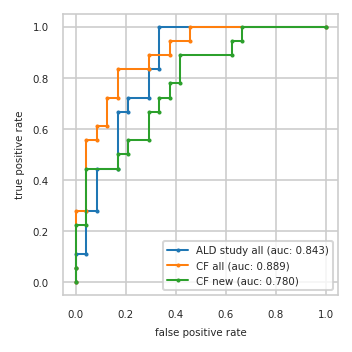

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.111  0.000 0.278  0.000 0.222
3          0.042 0.111  0.042 0.278  0.042 0.222
4          0.042 0.278  0.042 0.556  0.042 0.444
5          0.083 0.278  0.083 0.556  0.167 0.444
6          0.083 0.444  0.083 0.611  0.167 0.500
7          0.167 0.444  0.125 0.611  0.208 0.500
8          0.167 0.667  0.125 0.722  0.208 0.556
9          0.208 0.667  0.167 0.722  0.292 0.556
10         0.208 0.722  0.167 0.833  0.292 0.667
11         0.292 0.722  0.292 0.833  0.333 0.667
12         0.292 0.833  0.292 0.889  0.333 0.722
13         0.333 0.833  0.375 0.889  0.375 0.722
14         0.333 1.000  0.375 0.944  0.375 0.778
15         1.000 1.000  0.458 0.944  0.417 0.778
16           NaN   NaN  0.458 1.000  0.417 0.889
17           NaN   NaN  1.000 1.000  0.625 0.889
18           NaN   NaN    NaN   NaN  0.625 0.944
19           NaN   NaN    NaN   NaN  0.667 0.944
20           NaN   NaN    NaN   NaN  0.667 1.000
21           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,A0A0B4J1V0,E5RK69;E7EMC6;P08133;P08133-2,P01704
2,Q15782;Q15782-6,P02741,A0A075B7B8
3,P00740;P00740-2,Q9Y2T3;Q9Y2T3-3,P31321
4,P61981,P51688,P51688
5,P04075,None,Q96GD0
6,None,None,A0A0B4J1V6
7,None,None,A0A1W2PQ94;B4DS77;B4DS77-2;B4DS77-3
8,None,None,Q9NUQ9


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


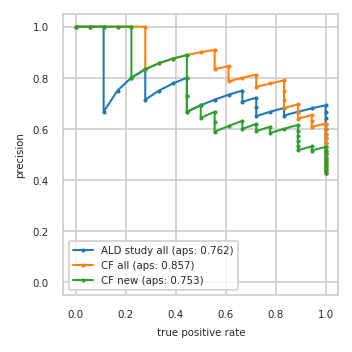

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.529 1.000     0.529 1.000     0.529 1.000
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.562 1.000     0.562 1.000     0.531 0.944
11         0.581 1.000     0.581 1.000     0.516 0.889
12         0.600 1.000     0.600 1.000     0.533 0.889
13         0.621 1.000     0.621 1.000     0.552 0.889
14         0.643 1.000     0.607 0.944     0.571 0.889
15         0.667 1.000     0.630 0.944     0.593 0.889
16         0.692 1.000     0.654 0.944     0.615 0.889
17         0.680 0.944     0.640 0.889     0.600 0.833
18         0.667 0.889     0.667 0.889     0.583 0.778
19         0.652 0.833     0.696 0.889     0.609 0.778
20         0.682 0.833     0.682 0.833     0.591 0.722
21         0.667 0.778     0.714 0.833     0.619 0.722
22         0.650 0.722     0.750 0.833     0.600 0.667
23         0.684 0.722     0.789 0.833     0.632 0.667
24         0.722 0.722     0.778 0.778     0.611 0.611
25         0.706 0.667     0.765 0.722     0.588 0.556
26         0.750 0.667     0.812 0.722     0.625 0.556
27         0.733 0.611     0.800 0.667     0.667 0.556
28         0.714 0.556     0.786 0.611     0.643 0.500
29         0.692 0.500     0.846 0.611     0.692 0.500
30         0.667 0.444     0.833 0.556     0.667 0.444
31         0.727 0.444     0.909 0.556     0.727 0.444
32         0.800 0.444     0.900 0.500     0.800 0.444
33         0.778 0.389     0.889 0.444     0.889 0.444
34         0.750 0.333     0.875 0.389     0.875 0.389
35         0.714 0.278     0.857 0.333     0.857 0.333
36         0.833 0.278     0.833 0.278     0.833 0.278
37         0.800 0.222     1.000 0.278     0.800 0.222
38         0.750 0.167     1.000 0.222     1.000 0.222
39         0.667 0.111     1.000 0.167     1.000 0.167
40         1.000 0.111     1.000 0.111     1.000 0.111
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


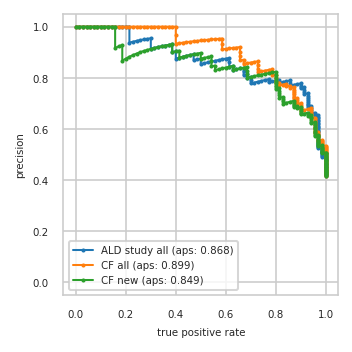

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


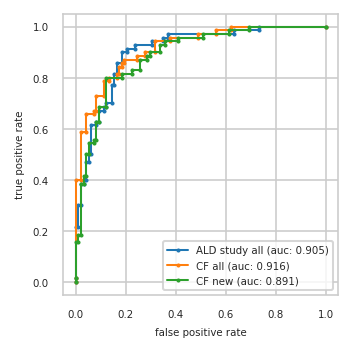

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}